In [1]:
import VariationalBayes.Parameters as par
from VariationalBayes.MultinomialParams import SimplexParam

import math

from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#import copy
from copy import deepcopy
import scipy
from scipy import optimize
from scipy import stats

In [2]:
# Number of data points:
n_num = 1000

# Dimension of observations:
d_num = 2

# Number of clusters:
k_num = 5

true_pi = np.linspace(0.2, 0.8, k_num)
true_pi = true_pi / np.sum(true_pi)

true_z = np.random.multinomial(1, true_pi, n_num)
true_z_ind = np.full(n_num, -1)
for row in np.argwhere(true_z):
    true_z_ind[row[0]] = row[1]

mu_prior_mean = np.full(d_num, 0.)
mu_prior_cov = np.diag(np.full(d_num, 3 ** 2))
mu_prior_info = np.linalg.inv(mu_prior_cov)
true_mu = np.random.multivariate_normal(mu_prior_mean, mu_prior_cov, k_num)

true_sigma = np.array([ np.diag(np.full(d_num, 2 ** 2)) + np.full((d_num, d_num), 0.1) \
                        for k in range(k_num) ])

x = np.array([ np.random.multivariate_normal(true_mu[true_z_ind[n]], true_sigma[true_z_ind[n]]) \
               for n in range(n_num) ])


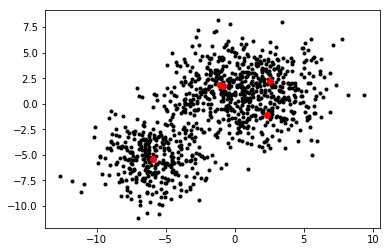

In [3]:
# Never a bad idea to visualize the dataz

plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

In [4]:
# Build an object to contain a variational approximation to a K-dimensional multivariate normal.
params = par.ModelParamsDict()

true_info = np.array([ np.linalg.inv(true_sigma[k, :, :]) for k in range(k_num) ])
params.push_param(par.PosDefMatrixParamVector(name='info', length=k_num, matrix_size=d_num, val=true_sigma))
params.push_param(par.ArrayParam(name='mu', shape=(k_num, d_num), val=true_mu))
params.push_param(SimplexParam(name='pi', shape=(1, k_num), val=np.expand_dims(true_pi, axis=0)))
params.push_param(SimplexParam(name='e_z', shape=(n_num, k_num), val=np.full(true_z.shape, 1. / k_num)))
e_z = params['e_z'].get()

In [5]:
prior_params = par.ModelParamsDict()
prior_params.push_param(par.VectorParam(name='mu_prior_mean', size=d_num, val=mu_prior_mean))
prior_params.push_param(par.PosDefMatrixParam(name='mu_prior_info', size=d_num, val=mu_prior_info))
prior_params.push_param(par.ScalarParam(name='alpha', val=2.0))
prior_params.push_param(par.ScalarParam(name='dof', val=d_num + 2.0))

In [9]:
def data_log_likelihood(mu, info, e_z, x):
    k_num = e_z.shape[1]
    assert k_num == mu.shape[0]
    assert k_num == info.shape[0]
    log_lik = 0.0
    # I would be interested to see how this could work without a loop.
    for k in range(k_num):
        x_centered = x - np.expand_dims(mu[k, :], axis=0)
        log_lik = log_lik - 0.5 * np.einsum('ni, ij, nj, n', x_centered, info[k, :, :], x_centered, e_z[:, k])
        sign, logdet = np.linalg.slogdet(info[k, :, :])
        assert sign > 0
        log_lik = log_lik + 0.5 * logdet * np.sum(e_z[:, k])
    return log_lik

def indicator_log_likelihood(e_z, pi):
    return np.sum(np.matmul(e_z, np.log(pi.T)))

def mu_prior(mu, mu_prior_mean, mu_prior_info):
    k_num = mu.shape[0]
    d_num = len(mu_prior_mean)
    assert mu.shape[1] == d_num
    assert mu_prior_info.shape[0] == d_num
    assert mu_prior_info.shape[1] == d_num
    mu_prior_val = 0.0
    for k in range(k_num):
        mu_centered = mu[k, :] - mu_prior_mean
        mu_prior_val += -0.5 * np.matmul(np.matmul(mu_centered, mu_prior_info), mu_centered)
    return mu_prior_val
    
def pi_prior(pi, alpha):
    return np.sum(alpha * np.log(pi))

def info_prior(info, dof):
    k_num = info.shape[0]
    d_num = info.shape[1]
    assert d_num == info.shape[2]
    assert dof > d_num - 1
    # Not a complete Wishart prior
    # TODO: cache the log determinants.
    info_prior_val = 0.0
    for k in range(k_num):
        sign, logdet = np.linalg.slogdet(info[k, :, :])
        info_prior_val += 0.5 * (dof - d_num - 1) * logdet
    return info_prior_val

def multinoulli_entropy(e_z):
    return -1 * np.sum(e_z * np.log(e_z))
    

data_log_likelihood(true_mu, true_info, e_z, x)
indicator_log_likelihood(e_z, true_pi)
mu_prior(true_mu, mu_prior_mean, mu_prior_info)
pi_prior(true_pi, 2.0)
info_prior(true_info, d_num + 2)
multinoulli_entropy(e_z)

1609.4379124341003

In [14]:
class Objective(object):
    def __init__(self, x, params, prior_params):
        self.x = x
        self.params = deepcopy(params)
        self.prior_params = deepcopy(prior_params)
        
        self.kl_grad = grad(self.kl)
        self.kl_hessian = hessian(self.kl)
        self.kl_hvp = hessian_vector_product(self.kl)
        
    def elbo(self, free_params):
        self.params.set_free(free_params)
        elbo = 0.0
        info = self.params['info'].get()
        mu = self.params['mu'].get()
        e_z = self.params['e_z'].get()
        pi = self.params['pi'].get()
        
        # Data:
        elbo += data_log_likelihood(mu, info, e_z, self.x)
        elbo += indicator_log_likelihood(e_z, pi)
        
        # Priors:
        mu_prior_mean = self.prior_params['mu_prior_mean'].get()
        mu_prior_info = self.prior_params['mu_prior_info'].get()
        elbo += mu_prior(mu, mu_prior_mean, mu_prior_info)
        elbo += pi_prior(pi, self.prior_params['alpha'].get())
        elbo += info_prior(info, self.prior_params['dof'].get())
        
        # Entropy
        elbo += multinoulli_entropy(e_z)
        
        return elbo
    
    def kl(self, free_params):
        return -1. * self.elbo(free_params)

In [17]:
obj = Objective(x, params, prior_params)
free_par = params.get_free()
obj.kl(free_par)
grad = obj.kl_grad(free_par)
hvp = obj.kl_hvp(free_par, grad)



array([  3.93005163e+08,   8.44817637e+07,   6.57545968e+08, ...,
         1.59291661e+06,  -1.31701247e+05,  -1.49975216e+06])